<div style="background-color:#e8f2ff; padding:16px; border-radius:8px;">

### Strategy 3: Mean Reversion | Bollinger Band Long / Short  

**Strategy Rules**

- Compute **Bollinger Bands (20-period, ±2σ)** on the close price
- **Go Long** when price **closes below the Lower Bollinger Band**
  <br> 
- **Go Short** when price **closes above the Upper Bollinger Band**
  <br> 
- Positions **flip between Long (+1) and Short (-1)** on opposite signals
- The strategy **remains always in the market** (no flat state)
</div>

In [43]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
data = yf.download("^NSEI", start="2022-01-01", end="2024-12-31" )

[*********************100%***********************]  1 of 1 completed


In [45]:
data.head(2)

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2022-01-03,17625.699219,17646.650391,17383.300781,17387.150391,200500
2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391,247400


In [46]:
data.columns = ['close', 'high', 'low', 'open', 'volume']

In [47]:
data.head(2)

,close,high,low,open,volume
Date,,,,,
2022-01-03,17625.699219,17646.650391,17383.300781,17387.150391,200500
2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391,247400


In [48]:
data = data.drop(['volume'], axis=1)

In [49]:
data.head(2)

,close,high,low,open
Date,,,,
2022-01-03,17625.699219,17646.650391,17383.300781,17387.150391
2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391


In [50]:
data.index.min()

Timestamp('2022-01-03 00:00:00')

In [51]:
data.index.max()

Timestamp('2024-12-30 00:00:00')

### WORK WITH A COPY 

In [52]:
df = data.copy()

In [53]:
#Compute Bollinger Bands (20-period, ±2σ) on the adjusted close price
df['sma20'] = df['close'].rolling(window=20).mean()
df['std20'] = df['close'].rolling(window=20).std()
df['upperband'] = df['sma20'] + (2 * df['std20'])
df['lowerband'] = df['sma20'] - (2 * df['std20'])

In [54]:
buy_condition = df['close'] < df['lowerband']

sell_condition = df['close'] > df['upperband']

In [55]:
df['signal_long'] = np.where(buy_condition,1 , 0)

df['signal_short'] = np.where(sell_condition, -1, 0)

In [56]:
df['signal'] = df['signal_long'] + df['signal_short']

In [57]:
df['signal_shift'] = df['signal'].shift()

In [58]:
#df['signal'].value_counts()

In [59]:
# Create the position column
df['position'] = df['signal_shift'].replace(0, np.nan).ffill().fillna(0)

In [60]:
df['position'].value_counts()

position
 1.0    357
-1.0    343
 0.0     38
Name: count, dtype: int64

In [61]:
df['asset_returns'] = df['close'].pct_change()
df['strategy_returns'] = df['position'] * df['asset_returns']

df['asset_returns_eq_cum'] = (1 + df['asset_returns']).cumprod()
df['strategy_returns_eq_cum'] = (1 + df['strategy_returns']).cumprod()

returns1 = df['strategy_returns_eq_cum'].dropna()
asset1 = df['asset_returns_eq_cum'].dropna()

print("Strategy Returns", np.round(returns1.iloc[-1], 2))
print("Asset Returns", np.round(asset1.iloc[-1], 2))
print("Strategy Return (%)", np.round((returns1.iloc[-1] - 1) * 100, 2))
print("Asset Return (%)", np.round((asset1.iloc[-1] - 1) * 100, 2))

Strategy Returns 1.11
Asset Returns 1.34
Strategy Return (%) 10.92
Asset Return (%) 34.15


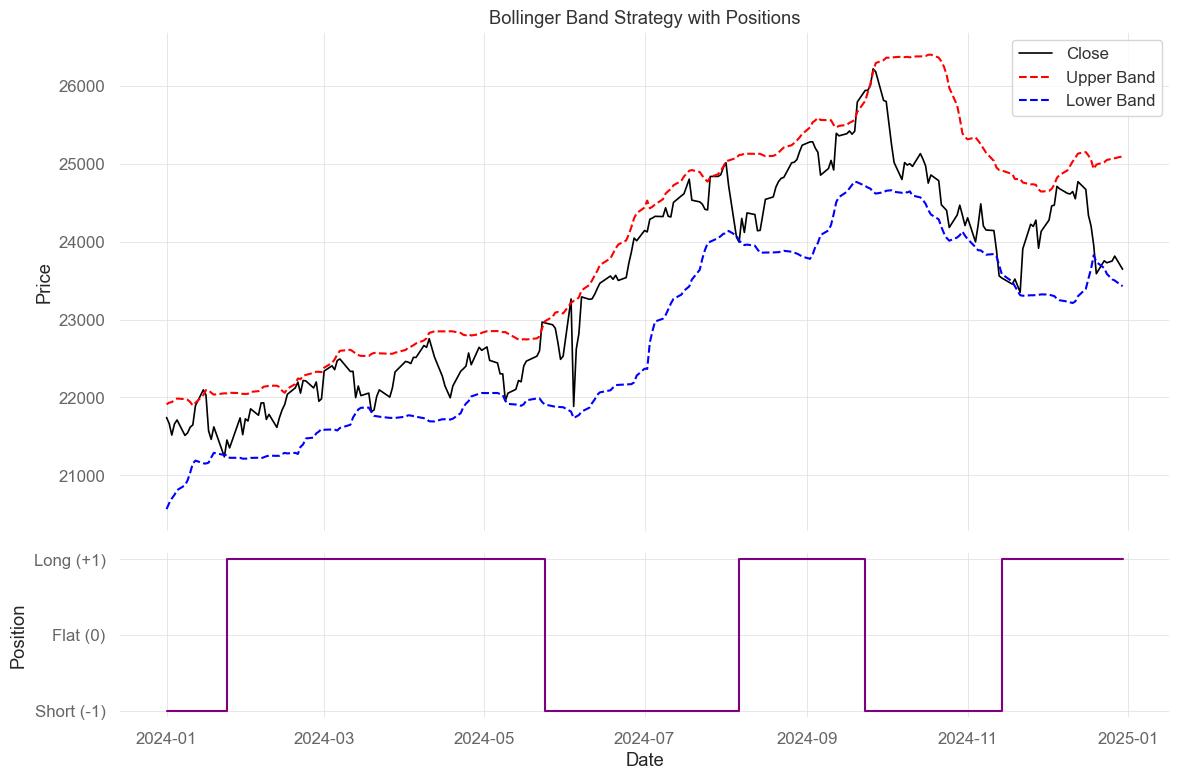

In [62]:
import matplotlib.pyplot as plt

# Slice by year
df_year = df.loc['2024']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True,
                               gridspec_kw={'height_ratios':[3,1]})

# --- TOP: Price + Bollinger Bands ---
ax1.plot(df_year.index, df_year['close'], label='Close', color='black', linewidth=1.2)
ax1.plot(df_year.index, df_year['upperband'], '--', label='Upper Band', color='red')
ax1.plot(df_year.index, df_year['lowerband'], '--', label='Lower Band', color='blue')
ax1.set_title("Bollinger Band Strategy with Positions")
ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(True)

# --- BOTTOM: Position series ---
ax2.step(df_year.index, df_year['position'], where='post', color='purple')
ax2.set_ylabel("Position")
ax2.set_xlabel("Date")
ax2.set_yticks([-1,0,1])
ax2.set_yticklabels(['Short (-1)','Flat (0)','Long (+1)'])
ax2.grid(True)

plt.tight_layout()
plt.show()

<div style="background-color:#e8f2ff; padding:16px; border-radius:8px;">

### Strategy 4: Buy and Hold (Blue Chips) 

**Strategy Rules**
- Select **5 stocks** from the **Nifty50 Universe**  
- **Hold positions continuously** without exits 
- Returns are driven by **long-term price appreciation**  
- The strategy **remains fully invested** at all times  

**Evaluate Buy and Hold Portfolio Performance**
- Plot the Cumulative Portfolio Equity Curve 
- Evaluate **CAGR, volatility, and drawdown**  
</div>

In [63]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

# Define stock symbols (Yahoo Finance format for NSE stocks)
symbols = ['TCS.NS', 'SUNPHARMA.NS', 'HDFCBANK.NS', 'RELIANCE.NS', 'JSWSTEEL.NS']

# Download last 10 years of daily data
data = yf.download(tickers=symbols, start='2014-01-01', end='2024-12-31')['Close']

# Display the first few rows
print(data.head())

[*********************100%***********************]  5 of 5 completed

Ticker      HDFCBANK.NS  JSWSTEEL.NS  RELIANCE.NS  SUNPHARMA.NS      TCS.NS
Date                                                                       
2014-01-01   150.498581    89.249580   188.334106    526.620117  825.898865
2014-01-02   148.654526    88.695824   185.409912    528.000183  831.153992
2014-01-03   150.034744    87.373001   183.132004    533.382874  852.325623
2014-01-06   149.717972    90.910820   181.161362    541.249817  858.999512
2014-01-07   150.328903    90.317513   178.438492    546.724365  846.169739


In [64]:
data.index = pd.to_datetime(data.index)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2710 entries, 2014-01-01 to 2024-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HDFCBANK.NS   2710 non-null   float64
 1   JSWSTEEL.NS   2710 non-null   float64
 2   RELIANCE.NS   2710 non-null   float64
 3   SUNPHARMA.NS  2710 non-null   float64
 4   TCS.NS        2710 non-null   float64
dtypes: float64(5)
memory usage: 127.0 KB


In [66]:
stock_data = data.copy()

### Resampling using `.resample()`

`.resample()` → Used to **group time series DataFrames** into a new frequency.

**Syntax:**  
`df.resample(freq).last()`

- `.resample()` requires a **DatetimeIndex** in the DataFrame  
- Common frequencies:  
  - `'D'` → Daily  
  - `'W'` → Weekly  
  - `'M'` → Monthly  
  - `'Q'` → Quarterly  
  - `'Y'` → Yearly  

In [67]:
# Convert daily to monthly frequency
monthly_stocks_data = stock_data.resample('M').last()

In [68]:
monthly_stocks_data.head()

Ticker,HDFCBANK.NS,JSWSTEEL.NS,RELIANCE.NS,SUNPHARMA.NS,TCS.NS
Date,,,,,
2014-01-31,142.206055,80.631393,176.118210,541.663818,861.087158
2014-02-28,151.505417,76.992485,169.507019,593.189453,874.420471
2014-03-31,169.425415,91.064644,197.223175,528.828430,819.628418
2014-04-30,163.203217,95.195732,198.293243,582.240295,841.164795
2014-05-31,179.369659,106.477203,227.832855,561.859924,822.779358


In [69]:
# Calculate monthly percentage change
monthly_percent_change = monthly_stocks_data.pct_change()

# Calculate portfolio returns, it’s the arithmetic average of the component returns.
portfolio_returns = monthly_percent_change.mean(axis=1)

In [70]:
monthly_percent_change

Ticker,HDFCBANK.NS,JSWSTEEL.NS,RELIANCE.NS,SUNPHARMA.NS,TCS.NS
Date,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN
2014-02-28,0.065394,-0.045130,-0.037538,0.095125,0.015484
2014-03-31,0.118280,0.182773,0.163510,-0.108500,-0.062661
2014-04-30,-0.036725,0.045364,0.005426,0.101000,0.026276
2014-05-31,0.099057,0.118508,0.148969,-0.035003,-0.021857
...,...,...,...,...,...
2024-08-31,0.013090,0.013843,0.006193,0.059499,0.038401
2024-09-30,0.058128,0.094517,-0.021893,0.057668,-0.062641
2024-10-31,0.002107,-0.064463,-0.097879,-0.040380,-0.068026


In [71]:
portfolio_returns

Date
2014-01-31         NaN
2014-02-28    0.018667
2014-03-31    0.058680
2014-04-30    0.028268
2014-05-31    0.061935
                ...   
2024-08-31    0.026205
2024-09-30    0.025156
2024-10-31   -0.053728
2024-11-30    0.009343
2024-12-31   -0.022197
Freq: ME, Length: 132, dtype: float64

In [72]:
portfolio_returns = portfolio_returns.dropna()

In [73]:
# Calculate cumulative portfolio returns
cum_portfolio_returns = (portfolio_returns+1).cumprod()

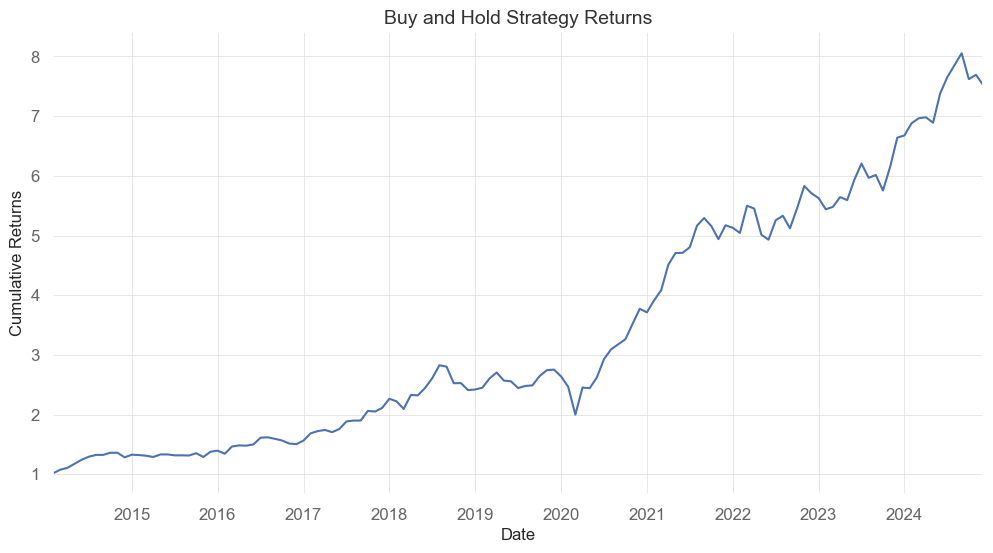

In [74]:
# Plot cumulative strategy returns
cum_portfolio_returns.plot(figsize=(12, 6))
# Set title and labels
plt.title('Buy and Hold Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
# Add gridlines
plt.grid(True)

In [75]:
# --- CAGR ---
n_months = len(portfolio_returns)
cumulative_return = (1 + portfolio_returns).prod()
cagr = cumulative_return ** (12 / n_months) - 1

# --- Volatility (annualized) ---
volatility = portfolio_returns.std() * np.sqrt(12)

# --- Drawdowns ---
cumulative = (1 + portfolio_returns).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print("CAGR:", np.round(cagr, 2))
print("Volatility:", np.round(volatility, 2))
print("Max Drawdown:", np.round(max_drawdown, 2))

CAGR: 0.2
Volatility: 0.17
Max Drawdown: -0.29


<div style="background-color:#e8f2ff; padding:16px; border-radius:8px;">

### A Glimse of Technical Analysis Library  

**Overview**  
- **TA-Lib** is a widely used open-source library for **financial market analysis**  
- Provides **over 150 functions** for **technical indicators** (e.g., RSI, MACD, Bollinger Bands) 

**Use Cases**  
- Building **trading strategies** with technical indicators  
  
</div>

In [94]:
import talib as ta

In [95]:
help(ta)

Help on package talib:

NAME
    talib

PACKAGE CONTENTS
    _ta_lib
    abstract
    deprecated
    stream

SUBMODULES
    func

FUNCTIONS
    ACCBANDS(high, low, close, timeperiod=-2147483648)
        ACCBANDS(ndarray high, ndarray low, ndarray close, int timeperiod=-0x80000000)
        
        ACCBANDS(high, low, close[, timeperiod=?])
        
        Acceleration Bands (Overlap Studies)
        
        Inputs:
            prices: ['high', 'low', 'close']
        Parameters:
            timeperiod: 20
        Outputs:
            upperband
            middleband
            lowerband
    
    ACOS(real)
        ACOS(ndarray real)
        
        ACOS(real)
        
        Vector Trigonometric ACos (Math Transform)
        
        Inputs:
            real: (any ndarray)
        Outputs:
            real
    
    AD(high, low, close, volume)
        AD(ndarray high, ndarray low, ndarray close, ndarray volume)
        
        AD(high, low, close, volume)
        
        Chaikin

In [96]:
help(ta.RSI)

Help on function RSI in module talib._ta_lib:

RSI(real, timeperiod=-2147483648)
    RSI(ndarray real, int timeperiod=-0x80000000)
    
    RSI(real[, timeperiod=?])
    
    Relative Strength Index (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [116]:
data = yf.download("SUNPHARMA.NS", start='2024-01-01', end='2024-12-31')

[*********************100%***********************]  1 of 1 completed


In [117]:
data.columns = ['close', 'high', 'low', 'open', 'volume']
print(data.head(2))
data.info()

                  close         high          low         open   volume
Date                                                                   
2024-01-01  1237.588501  1241.221921  1229.977860  1238.325015   733452
2024-01-02  1272.891968  1275.641667  1234.544228  1238.324974  3174447
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2024-01-01 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   245 non-null    float64
 1   high    245 non-null    float64
 2   low     245 non-null    float64
 3   open    245 non-null    float64
 4   volume  245 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.5 KB


In [118]:
df = data.copy()

In [119]:
# 3. Relative Strength Index (RSI)
df['RSI14'] = ta.RSI(df['close'], timeperiod=14)

# 4. Moving Average Convergence Divergence (MACD)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df['close'],
                                                         fastperiod=12,
                                                         slowperiod=26,
                                                         signalperiod=9)

# 5. Bollinger Bands
df['UpperBB'], df['MiddleBB'], df['LowerBB'] = ta.BBANDS(df['close'],
                                                         timeperiod=20,
                                                         nbdevup=2,
                                                         nbdevdn=2,
                                                         matype=0)

# 6. Average True Range (ATR)
df['ATR14'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)

In [120]:
df.tail()

,close,high,low,open,volume,RSI14,MACD,MACD_signal,MACD_hist,UpperBB,MiddleBB,LowerBB,ATR14
Date,,,,,,,,,,,,,
2024-12-23,1797.811279,1811.087327,1780.027401,1794.244611,1299181,52.308389,0.526447,-2.761932,3.288379,1826.176575,1780.842334,1735.508093,35.457591
2024-12-24,1802.170654,1814.802692,1786.467322,1798.108612,1121058,53.492723,1.445326,-1.920480,3.365807,1826.827471,1783.685779,1740.544087,34.948861
2024-12-26,1824.313843,1827.979683,1797.613232,1803.161397,1402706,59.054785,3.915183,-0.753348,4.668531,1828.237827,1788.238263,1748.238699,34.621546
2024-12-27,1844.029785,1848.735838,1819.756458,1828.425504,1668898,63.267199,7.378420,0.873006,6.505414,1827.442201,1794.529517,1761.616832,34.218534
2024-12-30,1866.470215,1878.210555,1837.837573,1844.822395,6021550,67.380609,11.797818,3.057968,8.739850,1842.444527,1799.631866,1756.819206,34.658137


In [121]:
dir(ta)

['ACCBANDS',
 'ACOS',
 'AD',
 'ADD',
 'ADOSC',
 'ADX',
 'ADXR',
 'APO',
 'AROON',
 'AROONOSC',
 'ASIN',
 'ATAN',
 'ATR',
 'AVGDEV',
 'AVGPRICE',
 'BBANDS',
 'BETA',
 'BOP',
 'CCI',
 'CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGS

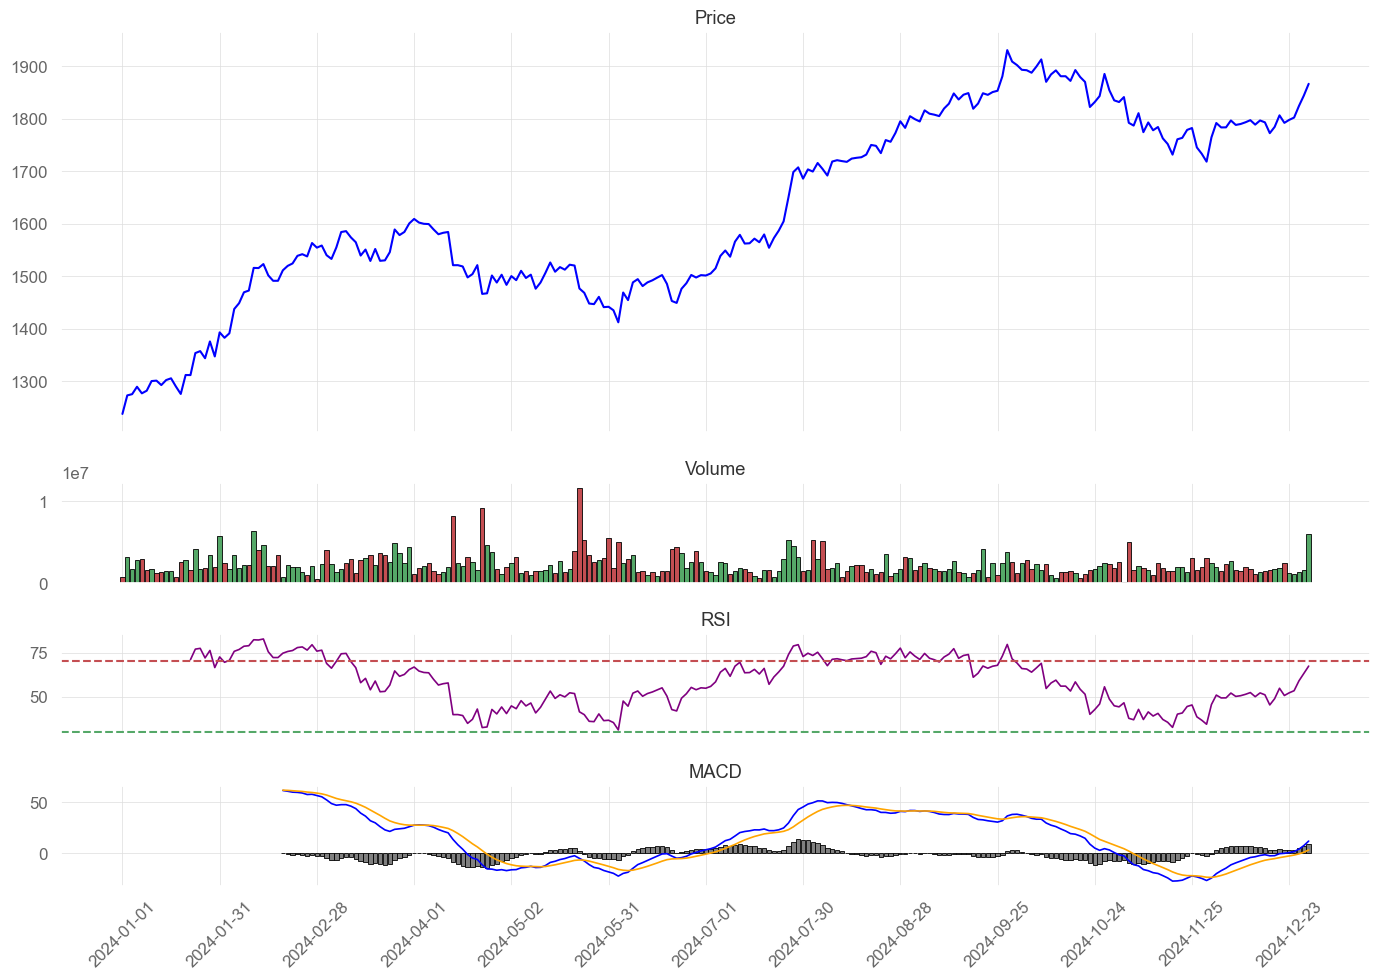

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Numeric x-axis (bulletproof for bars)
x = np.arange(len(df))

# Green if close > open else red
colors = ['g' if c > o else 'r' for c, o in zip(df['close'], df['open'])]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(14, 10), sharex=True,
    gridspec_kw={'height_ratios': [4, 1, 1, 1]}
)

# ---------- Price ----------
ax1.plot(x, df['close'], color='blue', linewidth=1.5)
ax1.set_title('Price')
ax1.grid(True)

# ---------- Volume (BOLD & WIDE) ----------
ax2.bar(
    x,
    df['volume'],
    color=colors,
    width=0.9,
    alpha=1.0,
    edgecolor='black',
    linewidth=0.6
)
ax2.set_title('Volume')
ax2.grid(True)

# ---------- RSI ----------
ax3.plot(x, df['RSI14'], color='purple', linewidth=1.2)
ax3.axhline(70, linestyle='--', color='r')
ax3.axhline(30, linestyle='--', color='g')
ax3.set_title('RSI')
ax3.grid(True)

# ---------- MACD ----------
ax4.plot(x, df['MACD'], color='blue', linewidth=1.2)
ax4.plot(x, df['MACD_signal'], color='orange', linewidth=1.2)
ax4.bar(
    x,
    df['MACD_hist'],
    color='gray',
    width=0.9,
    alpha=1.0,
    edgecolor='black',
    linewidth=0.6
)
ax4.set_title('MACD')
ax4.grid(True)

# ---------- X-axis labels (dates only at bottom) ----------
ax4.set_xticks(x[::20])
ax4.set_xticklabels(df.index.strftime('%Y-%m-%d')[::20], rotation=45)

plt.tight_layout()
plt.show();
